In [1]:
### Importing Libraries

import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt

import os
from PIL import Image
from pathlib import Path
import csv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
import keras

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [44]:
import librosa.display

songname = f'./genres/blues/blues.00000.au'
y, sr = librosa.load(songname, mono=True, duration=2, offset=0)
ps = librosa.feature.melspectrogram(y=y, sr=sr, hop_length = 256, n_fft = 512, n_mels=128)
ps = librosa.power_to_db(ps**2)
ps.shape

(128, 173)

In [47]:
dataset = []
genres = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 
        'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}

for genre, genre_number in genres.items():
    for filename in os.listdir(f'./genres/{genre}'):
        songname = f'./genres/{genre}/{filename}'
        for index in range(8):
            y, sr = librosa.load(songname, mono=True, duration=2, offset=index*)
            ps = librosa.feature.melspectrogram(y=y, sr=sr, hop_length = 256, n_fft = 512, n_mels=64)
            ps = librosa.power_to_db(ps**2)
            dataset.append( (ps, genre_number) )               

In [49]:
print(len(dataset))

import random

random.shuffle(dataset)

train = dataset[:3000]
valid = dataset[3000:3500]
test = dataset[3500:]

X_train, Y_train = zip(*train)
X_valid, Y_valid = zip(*valid)
X_test, Y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (64, 173, 1) ) for x in X_train])
X_valid = np.array([x.reshape( (64, 173, 1) ) for x in X_valid])
X_test = np.array([x.reshape( (64, 173, 1) ) for x in X_test])

# One-Hot encoding for classes
Y_train = np.array(keras.utils.to_categorical(Y_train, 10))
Y_valid = np.array(keras.utils.to_categorical(Y_valid, 10))
Y_test = np.array(keras.utils.to_categorical(Y_test, 10))


4000


In [50]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import AveragePooling2D

from keras import regularizers

model = Sequential()
input_shape=(64, 173, 1)
model.add(Conv2D(64, kernel_size=(4, 4),
                     activation='relu', #kernel_regularizer=regularizers.l2(0.04),
                     input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 4)))
model.add(Conv2D(64, (3, 5), activation='relu'
                    , kernel_regularizer=regularizers.l2(0.04)
                    ))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (2, 2), activation='relu'
       # , kernel_regularizer=regularizers.l2(0.04)
        ))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.04)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.04)))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 61, 170, 64)       1088      
_________________________________________________________________
batch_normalization_5 (Batch (None, 61, 170, 64)       256       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 30, 42, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 28, 38, 64)        61504     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 19, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 14, 19, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 13, 18, 64)      

In [53]:
from keras.callbacks import EarlyStopping

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=2)
hist = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data= (X_valid, Y_valid))

Train on 3000 samples, validate on 500 samples
Epoch 1/10
3000/3000 [==============================] - 84s 28ms/step - loss: 1.9206 - accuracy: 0.4810 - val_loss: 1.9140 - val_accuracy: 0.5040
Epoch 2/10
3000/3000 [==============================] - 89s 30ms/step - loss: 1.9231 - accuracy: 0.4880 - val_loss: 2.1063 - val_accuracy: 0.3800
Epoch 3/10
3000/3000 [==============================] - 86s 29ms/step - loss: 1.8750 - accuracy: 0.5117 - val_loss: 1.9306 - val_accuracy: 0.5220
Epoch 4/10
3000/3000 [==============================] - 81s 27ms/step - loss: 1.9011 - accuracy: 0.5270 - val_loss: 1.8447 - val_accuracy: 0.5860
Epoch 5/10
3000/3000 [==============================] - 88s 29ms/step - loss: 1.8937 - accuracy: 0.5177 - val_loss: 1.7991 - val_accuracy: 0.5680
Epoch 6/10
3000/3000 [==============================] - 86s 29ms/step - loss: 1.8676 - accuracy: 0.5477 - val_loss: 2.1223 - val_accuracy: 0.4660
Epoch 7/10
3000/3000 [==============================] - 93s 31ms/step - loss:

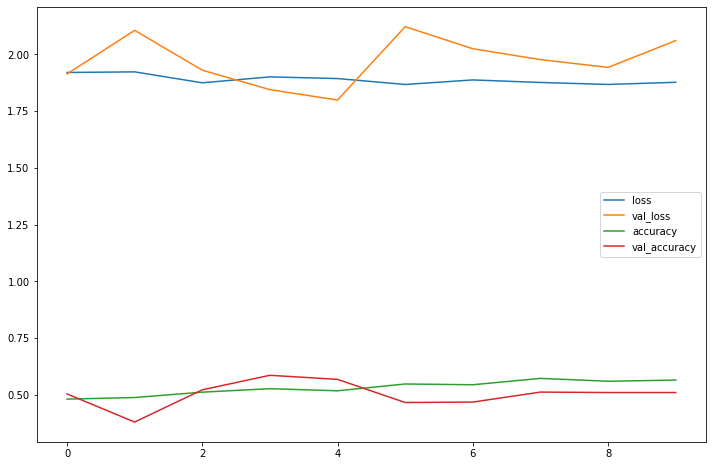

500/500 [==============================] - 3s 5ms/step
Test loss: 2.1491350803375244
Test accuracy: 0.4480000138282776


In [54]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['loss','val_loss', 'accuracy','val_accuracy'])
plt.show()

score = model.evaluate(X_test, Y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])